# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [2]:
# Cargar todas las librerías

import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import math
import seaborn as sns




## Cargar datos

In [3]:
# Carga los archivos de datos en diferentes DataFrames

# Carga los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('../datasets/megaline_calls.csv')
df_internet = pd.read_csv('../datasets/megaline_internet.csv') 
df_messages = pd.read_csv('../datasets/megaline_messages.csv')
df_plans = pd.read_csv('../datasets/megaline_plans.csv')
df_users = pd.read_csv('../datasets/megaline_users.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/megaline_calls.csv'

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [ ]:
# Imprime una muestra de los datos para las tarifas
df_plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


En esta caso al ser una tabla solo con dos filas donde vienen la descripcion de los 2 unicos planes, no hace falta modificar o arreglar nada. 

## Usuarios/as

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [ ]:
# Imprime una muestra de datos para usuarios
df_users.sample(10)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
282,1282,Annice,Calhoun,61,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-01,ultimate,NaN
358,1358,Vaughn,Maldonado,20,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-26,surf,2018-10-22
326,1326,Johnathon,Branch,21,"Greensboro-High Point, NC MSA",2018-02-06,surf,NaN
256,1256,Johnny,Wise,53,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-09-11,surf,NaN
380,1380,Lajuana,Kelley,35,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-09-04,ultimate,NaN
45,1045,Barney,Ortega,20,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-10-15,surf,NaN
124,1124,Jenell,Navarro,48,"New Haven-Milford, CT MSA",2018-02-19,ultimate,NaN
307,1307,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,NaN
354,1354,Leonel,Dyer,41,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-08-24,ultimate,NaN
434,1434,Kai,Barr,18,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-06,surf,NaN


Tanto el reg_date como el churn_date deben estar en fomatos datetime y no object, los Nan de churn_date tal vez se pueden sutituit con la fecha actual o dejarlos en NAn o tal vez con un 'active', El nombre de las ciudades viene muy largo y sobra MSA de ahi en fuera creo que todo bien 

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [ ]:
df_users['reg_date']= pd.to_datetime(df_users['reg_date'])
df_users['churn_date']= pd.to_datetime(df_users['churn_date'])

df_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [ ]:
df_users['is_active'] = df_users['churn_date'].isna()
df_users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,is_active
490,1490,Shane,Cortez,42,"Sacramento–Roseville–Folsom, CA MSA",2018-01-20,ultimate,NaT,True
332,1332,Lucas,Saunders,37,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-03-12,surf,NaT,True
324,1324,Romana,Moore,18,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",2018-04-04,surf,NaT,True
358,1358,Vaughn,Maldonado,20,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-26,surf,2018-10-22,False
331,1331,Lashandra,Ramos,54,"Dallas-Fort Worth-Arlington, TX MSA",2018-02-06,surf,NaT,True
104,1104,Thurman,Stephens,20,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-12-23,ultimate,NaT,True
276,1276,Karmen,Carney,20,"Phoenix-Mesa-Chandler, AZ MSA",2018-02-14,surf,NaT,True
64,1064,Gerardo,Ashley,46,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-03,surf,NaT,True
457,1457,Janean,Lynch,47,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-17,surf,NaT,True
464,1464,Burt,Burke,70,"Providence-Warwick, RI-MA MSA",2018-11-07,surf,NaT,True


In [ ]:
#se crea dataframe solo con usuario y plan 
user_plan= df_users[['user_id', 'plan']]
user_plan

,user_id,plan
0,1000,ultimate
1,1001,surf
2,1002,surf
3,1003,surf
4,1004,surf
...,...,...
495,1495,surf
496,1496,surf
497,1497,ultimate
498,1498,surf


## Llamadas

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [ ]:
# Imprime una muestra de datos para las llamadas

df_calls.sample(10)

,id,user_id,call_date,duration
17178,1066_284,1066,2018-10-17,5.14
136503,1494_345,1494,2018-07-19,4.72
27574,1105_125,1105,2018-12-14,3.38
70953,1252_372,1252,2018-08-13,4.97
16762,1065_130,1065,2018-11-29,19.53
96986,1346_212,1346,2018-10-20,0.00
57002,1203_393,1203,2018-07-24,8.87
62318,1223_500,1223,2018-12-02,0.00
97438,1347_264,1347,2018-12-14,0.32
3504,1011_357,1011,2018-07-28,14.32


call_date debe estar en formato datetime, porque hay llamadas que duraron 0? se deben eliminar?? la duracion deberia de estar en un formato de 60segundos?

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [ ]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [ ]:
df_calls['month'] = df_calls['call_date'].dt.month
df_calls.sample(10)

,id,user_id,call_date,duration,month
52831,1190_7,1190,2018-12-28,4.70,12
101809,1362_568,1362,2018-10-14,6.18,10
111060,1390_509,1390,2018-07-01,7.22,7
84491,1311_329,1311,2018-10-06,4.20,10
46794,1170_615,1170,2018-10-09,6.17,10
10499,1046_365,1046,2018-11-03,14.31,11
117927,1412_211,1412,2018-10-08,21.43,10
8466,1039_406,1039,2018-11-01,13.47,11
85548,1313_528,1313,2018-06-23,3.77,6
86280,1318_165,1318,2018-10-27,15.58,10


## Mensajes

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [ ]:
# Imprime una muestra de datos para los mensajes
df_messages.sample(15)


,id,user_id,message_date
43639,1290_11,1290,2018-11-14
47896,1324_621,1324,2018-06-21
22625,1134_17,1134,2018-10-18
56091,1355_79,1355,2018-10-29
32981,1205_56,1205,2018-12-05
26629,1162_5,1162,2018-12-15
56959,1362_24,1362,2018-03-04
4867,1045_155,1045,2018-11-14
30910,1194_69,1194,2018-12-01
58007,1365_163,1365,2018-11-07


message_date se debe poner en formato datetime

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [ ]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [ ]:
df_messages['month'] = df_messages['message_date'].dt.month
df_messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

In [ ]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [ ]:
# Imprime una muestra de datos para el tráfico de internet
df_internet.sample(10)



,id,user_id,session_date,mb_used
23936,1110_194,1110,2018-09-14,332.63
60649,1276_133,1276,2018-11-30,0.00
97544,1460_89,1460,2018-07-27,141.44
98197,1465_1,1465,2018-10-20,0.00
52350,1236_199,1236,2018-07-03,414.80
41409,1185_446,1185,2018-08-16,186.22
77099,1361_128,1361,2018-09-01,14.65
35586,1160_290,1160,2018-07-11,549.96
76835,1359_528,1359,2018-12-20,400.03
12152,1059_261,1059,2018-07-24,0.00


[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [ ]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [ ]:
df_internet['month'] = df_internet['session_date'].dt.month
df_internet

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,10
104821,1499_216,1499,2018-12-30,304.72,12
104822,1499_217,1499,2018-09-22,292.75,9
104823,1499_218,1499,2018-12-07,0.00,12


## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [ ]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [ ]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_by_user = df_calls.groupby(['month', 'user_id'])['id'].count()
calls_by_user

month  user_id
1      1042       18
       1077       42
       1185       23
       1196       42
       1214        5
                  ..
12     1495       65
       1496       40
       1497       54
       1498       39
       1499       65
Name: id, Length: 2258, dtype: int64

In [ ]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_by_user = df_calls.groupby(['month', 'user_id'])['duration'].sum()
minutes_by_user


month  user_id
1      1042       106.83
       1077       275.07
       1185       170.29
       1196       272.56
       1214        14.73
                   ...  
12     1495       467.47
       1496       278.61
       1497       276.53
       1498       324.77
       1499       468.10
Name: duration, Length: 2258, dtype: float64

In [ ]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_by_user = df_messages.groupby(['month', 'user_id'])['id'].count()
print(messages_by_user.sample(10))

print(messages_by_user.isna().sum())

month  user_id
11     1141       15
7      1167       59
10     1257       30
11     1254       91
10     1279       23
3      1299        7
9      1420        3
7      1358        3
9      1179       21
10     1175       31
Name: id, dtype: int64
0


In [ ]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet_by_user = df_internet.groupby(['month', 'user_id'])['mb_used'].sum()
print(internet_by_user)

month  user_id
1      1042        1854.93
       1077       10635.64
       1185        6812.77
       1196        8908.61
       1214        1315.35
                    ...   
12     1495       24097.40
       1496       16438.99
       1497       11106.55
       1498       23137.69
       1499       22059.21
Name: mb_used, Length: 2277, dtype: float64


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]


df_calls 
df_internet 
df_messages 
df_users

In [ ]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
merge_1 = pd.merge(
    calls_by_user,
    minutes_by_user,
    left_index=True,
    right_index=True
)

merge_1.columns = ['calls_count', 'minutes_sum']


In [ ]:
merge_2 = pd.merge(
    merge_1,
    messages_by_user,
    left_index=True,
    right_index=True,
    how='left'
)

merge_2.columns = ['calls_count', 'minutes_sum', 'message_sent'] # faltaria el de internet

# faltaria agregar las columnas de las tarifas
merge_2

calls_count  minutes_sum  message_sent
month user_id                                        
1     1042              18       106.83           NaN
      1077              42       275.07          37.0
      1185              23       170.29           NaN
      1196              42       272.56          23.0
      1214               5        14.73           2.0
...                    ...          ...           ...
12    1495              65       467.47           NaN
      1496              40       278.61          11.0
      1497              54       276.53          50.0
      1498              39       324.77           NaN
      1499              65       468.10           NaN

[2258 rows x 3 columns]

In [ ]:
merge_3 = pd.merge(
    merge_2, 
    internet_by_user,
    left_index=True,
    right_index=True,
    how='left'
) # falta el de internet
merge_3.columns = ['calls_count', 'minutes_sum', 'message_sent', 'internet_used']
merge_3

calls_count  minutes_sum  message_sent  internet_used
month user_id                                                       
1     1042              18       106.83           NaN        1854.93
      1077              42       275.07          37.0       10635.64
      1185              23       170.29           NaN        6812.77
      1196              42       272.56          23.0        8908.61
      1214               5        14.73           2.0        1315.35
...                    ...          ...           ...            ...
12    1495              65       467.47           NaN       24097.40
      1496              40       278.61          11.0       16438.99
      1497              54       276.53          50.0       11106.55
      1498              39       324.77           NaN       23137.69
      1499              65       468.10           NaN       22059.21

[2258 rows x 4 columns]

In [ ]:
merge_3['message_sent'] = merge_3['message_sent'].fillna(0)

In [ ]:
merge_3

calls_count  minutes_sum  message_sent  internet_used
month user_id                                                       
1     1042              18       106.83           0.0        1854.93
      1077              42       275.07          37.0       10635.64
      1185              23       170.29           0.0        6812.77
      1196              42       272.56          23.0        8908.61
      1214               5        14.73           2.0        1315.35
...                    ...          ...           ...            ...
12    1495              65       467.47           0.0       24097.40
      1496              40       278.61          11.0       16438.99
      1497              54       276.53          50.0       11106.55
      1498              39       324.77           0.0       23137.69
      1499              65       468.10           0.0       22059.21

[2258 rows x 4 columns]

In [ ]:
merge_3 = merge_3.reset_index()


In [ ]:
# Añade la información de la tarifa
# de usrs, sacar user_id y plan
# se hace merge, con merge_3
merge_4 = pd.merge(
    merge_3, 
    user_plan,
     on='user_id',
    how='left'
   
) 
merge_4

,month,user_id,calls_count,minutes_sum,message_sent,internet_used,plan
0,1,1042,18,106.83,0.0,1854.93,surf
1,1,1077,42,275.07,37.0,10635.64,ultimate
2,1,1185,23,170.29,0.0,6812.77,ultimate
3,1,1196,42,272.56,23.0,8908.61,ultimate
4,1,1214,5,14.73,2.0,1315.35,ultimate
...,...,...,...,...,...,...,...
2253,12,1495,65,467.47,0.0,24097.40,surf
2254,12,1496,40,278.61,11.0,16438.99,surf
2255,12,1497,54,276.53,50.0,11106.55,ultimate
2256,12,1498,39,324.77,0.0,23137.69,surf


In [ ]:
merge_5 = merge_4.merge(df_plans, 
                        left_on='plan', 
                        right_on='plan_name',
                        how='left')
merge_5

,month,user_id,calls_count,minutes_sum,message_sent,internet_used,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1,1042,18,106.83,0.0,1854.93,surf,50,15360,500,20,10,0.03,0.03,surf
1,1,1077,42,275.07,37.0,10635.64,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
2,1,1185,23,170.29,0.0,6812.77,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
3,1,1196,42,272.56,23.0,8908.61,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
4,1,1214,5,14.73,2.0,1315.35,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,12,1495,65,467.47,0.0,24097.40,surf,50,15360,500,20,10,0.03,0.03,surf
2254,12,1496,40,278.61,11.0,16438.99,surf,50,15360,500,20,10,0.03,0.03,surf
2255,12,1497,54,276.53,50.0,11106.55,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
2256,12,1498,39,324.77,0.0,23137.69,surf,50,15360,500,20,10,0.03,0.03,surf


[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [ ]:
# Calcula el ingreso mensual para cada usuario
def calc_monthly_revenue(row):
    # 1. Extraer datos de uso y tarifas:
    plan            = row['plan']  # 'surf' o 'ultimate'
    minutes_used    = row['minutes_sum']
    messages_used   = row['message_sent']
    mb_used         = row['internet_used']
    
    # 2. Extraer lo incluido en el plan y costes unitarios:
    monthly_fee     = row['usd_monthly_pay']    # cuota mensual
    min_incl        = row['minutes_included']   # minutos gratis
    msg_incl        = row['messages_included']  # SMS gratis
    mb_incl         = row['mb_per_month_included']  # MB gratis
    cost_per_min    = row['usd_per_minute']
    cost_per_msg    = row['usd_per_message']
    cost_per_gb     = row['usd_per_gb']
    
    # 3. Calcular excedentes:
    #    a) Minutos y mensajes: con un simple max(0, uso - incluido)
    extra_minutes   = max(0, minutes_used  - min_incl)
    extra_messages  = max(0, messages_used - msg_incl)
    
    #    b) Datos: redondeo total MB -> GB hacia arriba, y luego comparar
    used_gb_total   = math.ceil(mb_used / 1024.0)            # GB redondeados
    included_gb     = mb_incl / 1024.0                       # GB incluidos (p.ej. 15360 MB -> 15 GB)
    extra_gb        = max(0, used_gb_total - included_gb)    # GB excedentes
    
    # 4. Costos por excedentes:
    cost_extra_minutes  = extra_minutes  * cost_per_min
    cost_extra_messages = extra_messages * cost_per_msg
    cost_extra_gb       = extra_gb       * cost_per_gb
    
    # 5. Ingreso total del mes: cuota mensual + excedentes
    total_revenue = monthly_fee + cost_extra_minutes + cost_extra_messages + cost_extra_gb
    return total_revenue


In [ ]:
merge_5['internet_used'] = merge_5['internet_used'].fillna(0)


In [ ]:
merge_5['monthly_revenue'] = merge_5.apply(calc_monthly_revenue, axis=1)
merge_5

,month,user_id,calls_count,minutes_sum,message_sent,internet_used,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,monthly_revenue
0,1,1042,18,106.83,0.0,1854.93,surf,50,15360,500,20,10,0.03,0.03,surf,20.0
1,1,1077,42,275.07,37.0,10635.64,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
2,1,1185,23,170.29,0.0,6812.77,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
3,1,1196,42,272.56,23.0,8908.61,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
4,1,1214,5,14.73,2.0,1315.35,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,12,1495,65,467.47,0.0,24097.40,surf,50,15360,500,20,10,0.03,0.03,surf,110.0
2254,12,1496,40,278.61,11.0,16438.99,surf,50,15360,500,20,10,0.03,0.03,surf,40.0
2255,12,1497,54,276.53,50.0,11106.55,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0
2256,12,1498,39,324.77,0.0,23137.69,surf,50,15360,500,20,10,0.03,0.03,surf,100.0


In [ ]:
#Se cree un merge df que tambien tenga la region 
region_filter = df_users[['user_id', 'city' ]]
region_filter
merge_6 = merge_5.merge(region_filter,
                  on='user_id',
                  how='left'
                 )
merge_6 = merge_6[['month', 'user_id', 'plan', 'monthly_revenue', 'city']]
merge_6

,month,user_id,plan,monthly_revenue,city
0,1,1042,surf,20.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA"
1,1,1077,ultimate,70.0,"Charlotte-Concord-Gastonia, NC-SC MSA"
2,1,1185,ultimate,70.0,"Louisville/Jefferson County, KY-IN MSA"
3,1,1196,ultimate,70.0,"Los Angeles-Long Beach-Anaheim, CA MSA"
4,1,1214,ultimate,70.0,"San Francisco-Oakland-Berkeley, CA MSA"
...,...,...,...,...,...
2253,12,1495,surf,110.0,"New York-Newark-Jersey City, NY-NJ-PA MSA"
2254,12,1496,surf,40.0,"New Orleans-Metairie, LA MSA"
2255,12,1497,ultimate,70.0,"Los Angeles-Long Beach-Anaheim, CA MSA"
2256,12,1498,surf,100.0,"New York-Newark-Jersey City, NY-NJ-PA MSA"


<div class="alert alert-block alert-success">  
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>  
<b>Éxito</b> - Excelente trabajo en la limpieza, transformación y consolidación de datos. Has estructurado correctamente la conversión de tipos, el manejo de valores nulos y la agregación de datos por usuario y mes. La función de cálculo de ingresos mensuales es un gran aporte, asegurando que se consideren los costos por excedentes de manera detallada.  


</div>

## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

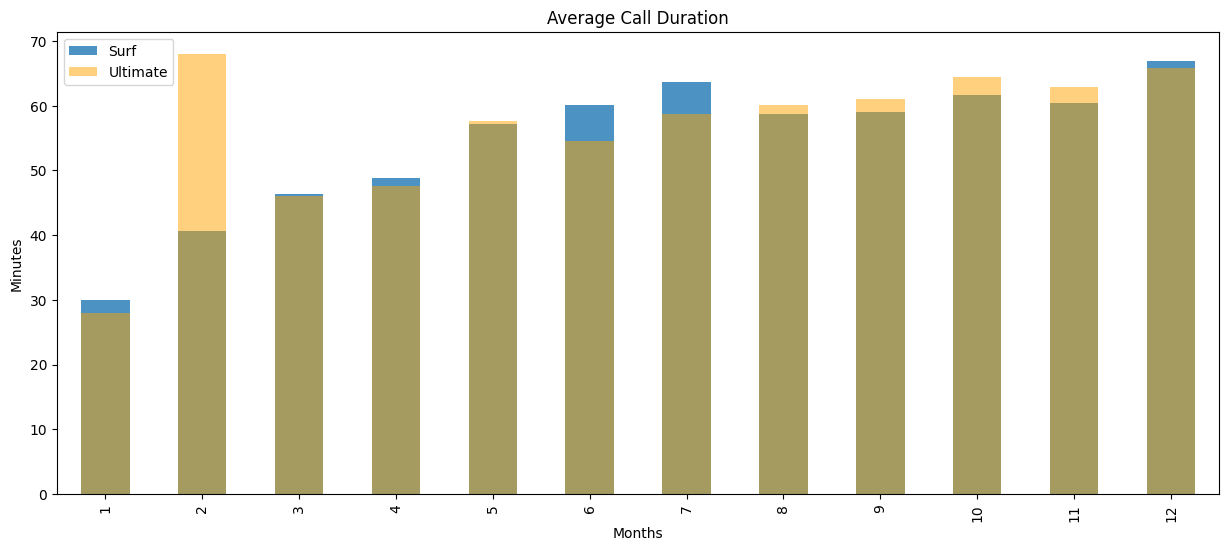

In [ ]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
calls_df =  merge_4.groupby(['plan', 'month'])['calls_count'].mean()



plt.figure(figsize=(15, 6)) 
calls_df['surf'].plot(kind='bar',
                     alpha=0.8)
calls_df['ultimate'].plot(kind='bar',
                         color='orange',
                         alpha= 0.5)
plt.xlabel('Months')
plt.ylabel('Minutes')
plt.title('Average Call Duration')
plt.legend(["Surf", "Ultimate"])



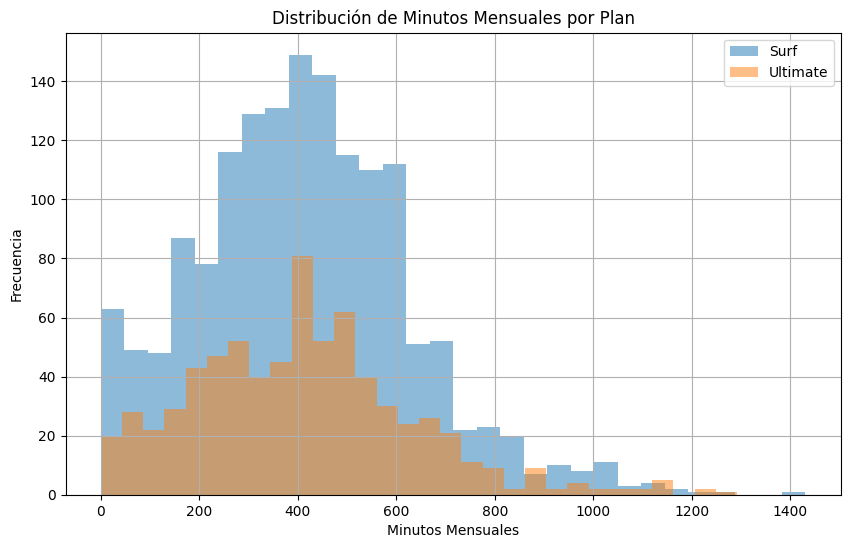

In [ ]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
surf_plan = merge_4[merge_4['plan'] == "surf"]
ultimate_plan = merge_4[merge_4['plan'] == "ultimate"]
plt.figure(figsize=(10, 6))

surf_plan['minutes_sum'].plot(kind='hist',
                              bins=30,
                             alpha=0.5)
ultimate_plan['minutes_sum'].plot(kind='hist',
                                  bins=30,
                                 alpha=0.5)
plt.xlabel("Minutos Mensuales")
plt.ylabel("Frecuencia")
plt.title("Distribución de Minutos Mensuales por Plan")
plt.legend(["Surf", "Ultimate"])
plt.grid(True)
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [ ]:
# Calcula la media y la varianza de la duración mensual de llamadas
media_llamadas = merge_4.groupby( 'month')['minutes_sum'].mean()
varianza_llamadas = np.var(media_llamadas)
print(media_llamadas)
print(varianza_llamadas)

month
1     186.388333
2     345.779333
3     302.306571
4     327.685493
5     386.147885
6     396.740284
7     420.053520
8     395.339087
9     402.148628
10    419.041246
11    413.120099
12    451.482696
Name: minutes_sum, dtype: float64
4727.511398272459


<AxesSubplot:xlabel='minutes_sum'>

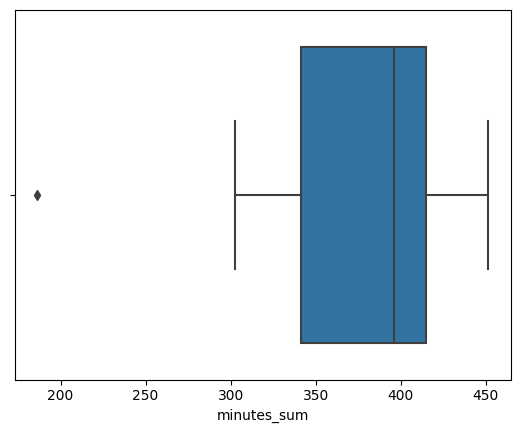

In [ ]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(media_llamadas)


<div class="alert alert-block alert-warning">  
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>  
<b>Atención</b> ⚠️ - Buen análisis comparativo de llamadas entre planes. Las visualizaciones son útiles, pero podrías complementar con la desviación estándar o una prueba estadística para confirmar diferencias significativas en el comportamiento. Sigue con este enfoque detallado.  
</div>

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas. ¿Su comportamiento varía en función del plan?]
La media de llamadas se encuentra en alrededor de 400 

<div class="alert alert-block alert-warning">  
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>  
<b>Atención</b> ⚠️ - Realizar conclusiones es fundamental para transformar datos en información útil. Un buen análisis no solo describe los datos, sino que extrae insights clave para la toma de decisiones. Asegúrate de interpretar los hallazgos con claridad.  
</div>

### Mensajes

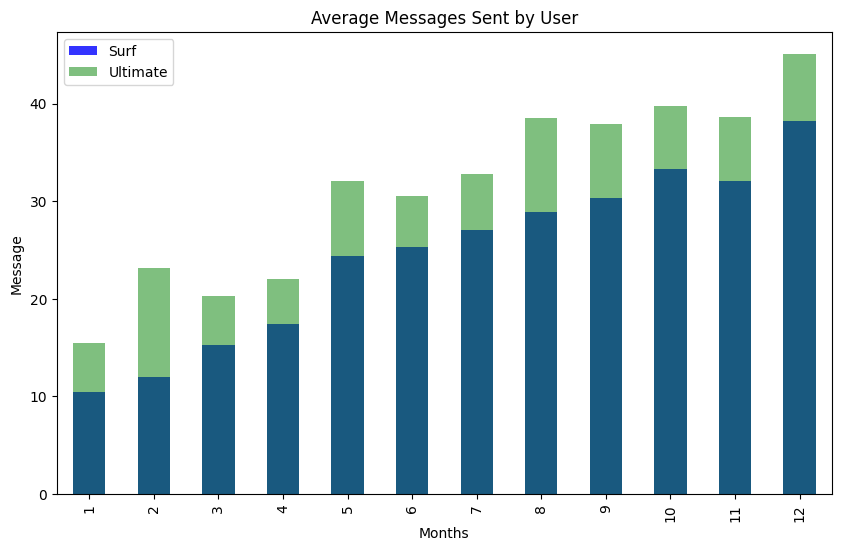

In [ ]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
message_month = merge_4.groupby(['plan', 'month'])["message_sent"].mean()
message_month

plt.figure(figsize=(10, 6)) 
message_month['surf'].plot(kind='bar',
                           color='blue',
                     alpha=0.8)
message_month['ultimate'].plot(kind='bar',
                         color='green',
                         alpha= 0.5)
plt.xlabel('Months')
plt.ylabel('Message')
plt.title('Average Messages Sent by User')
plt.legend(["Surf", "Ultimate"])



[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?]
No, el comportamiento no varia, ya que son muy similares las dos graficas

<div class="alert alert-block alert-warning">  
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>  
<b>Atención</b> ⚠️ - Buen uso de visualizaciones para comparar el envío de mensajes entre planes. Sin embargo, para confirmar que el comportamiento realmente no varía, podrías calcular medidas como la desviación estándar o aplicar una prueba estadística. Esto fortalecería la conclusión.  
</div>

### Internet

[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]

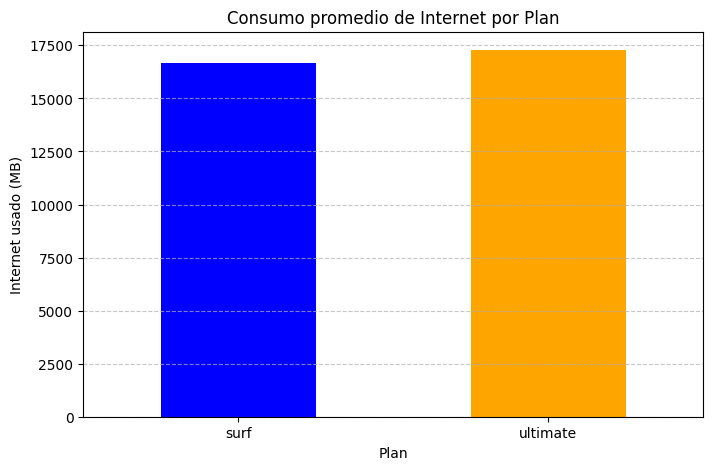

In [ ]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
internet_usage = merge_4.groupby("plan")["internet_used"].mean()
plt.figure(figsize=(8, 5))
internet_usage.plot(kind="bar", color=["blue", "orange"])
plt.title("Consumo promedio de Internet por Plan")
plt.xlabel("Plan")
plt.ylabel("Internet usado (MB)")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

No, el comportamiento no varia, ya que son muy similares las dos graficas. Usuarios sin depender del plan usan casi el mismo internet

<div class="alert alert-block alert-warning">  
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>  
<b>Atención</b> ⚠️ - Buen análisis visual del consumo de Internet entre planes. Sin embargo, para respaldar la afirmación de que el comportamiento no varía, podrías calcular la desviación estándar o realizar una prueba de hipótesis. Esto daría mayor certeza a la conclusión.  
</div>

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [ ]:
plan_revenue = merge_5.groupby('plan')['monthly_revenue'].describe()
plan_revenue

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1545.0,59.739583,53.396963,20.0,20.0,40.33,80.0,588.6372
ultimate,713.0,72.277700,11.351942,70.0,70.0,70.00,70.0,182.0000


[Elabora las conclusiones sobre cómo difiere el ingreso entre los planes.]
Los usuarios de surf suelen pagar mucho mas por su tarifa, en promedio 59 lo que es 39 mas de lo que esta establecido, su std es de 53 lo que significa que hay alta dispercion en los costos, lo que quiere decir que hay gran variabilidad en ellos. alrededor de el 50% de los valores, es decir de los usuarios estan en 40.33 eso quiere decir que la mitad pagan el doble de su precio establecido. El plan ultimate es mas estable, su media es casi igual a su costo, su desviacion estandar es baja de 11 lo que uqiere decir que sus costos son mas estables y consistentes, casi todos sus datos se encuentran en 70, si un usuario busca pagar algo estable esta es la mejo opcion. 

<div class="alert alert-block alert-success">  
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>  
<b>Éxito</b> - Excelente interpretación de los ingresos por plan. Has identificado correctamente la variabilidad en los costos del plan "Surf" y la estabilidad del plan "Ultimate". Resaltar la dispersión y la diferencia entre la media y la tarifa base es un análisis clave para entender la rentabilidad de cada plan.  

Para fortalecer aún más tu conclusión, podrías visualizar la distribución de los ingresos con un boxplot o histograma. Esto ayudaría a representar de manera más clara la variabilidad que mencionaste. Sigue con este nivel de detalle en el análisis.  
</div>

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [ ]:
# Prueba las hipótesis
surf_revenue = merge_5[merge_5['plan'] == 'surf']['monthly_revenue']  # Filtrar los ingresos del plan Surf
ultimate_revenue = merge_5[merge_5['plan'] == 'ultimate']['monthly_revenue']

print('Media ingresos plan Surf:', surf_revenue.mean())
print('Media ingresos plan Ultimate:', ultimate_revenue.mean())

alpha =  0.05

results = st.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

print('Valor-p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: Los ingresos promedio son significativamente diferentes")
else:
    print("No podemos rechazar la hipótesis nula: No hay suficiente evidencia para afirmar que los ingresos promedio son diferentes")


Media ingresos plan Surf: 59.73958291262136
Media ingresos plan Ultimate: 72.27769985974754
Valor-p: 2.8950294906188968e-18
Rechazamos la hipótesis nula: Los ingresos promedio son significativamente diferentes


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [ ]:
# Prueba las hipótesis
merge_6
ny_filter = merge_6.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')
other_filter = merge_6.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')

ny_revenue = ny_filter['monthly_revenue']
other_revenue = other_filter['monthly_revenue']

print('Media ingresos region NY-NJ:', ny_revenue.mean())
print('Media ingresos otras regiones:', other_revenue.mean())

alpha =  0.05

results = st.ttest_ind(ny_revenue, other_revenue, equal_var=False)

print('Valor-p:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: Los ingresos promedio son significativamente diferentes")
else:
    print("No podemos rechazar la hipótesis nula: No hay suficiente evidencia para afirmar que los ingresos promedio son diferentes")


Media ingresos region NY-NJ: 58.54780161725068
Media ingresos otras regiones: 64.71140498145205
Valor-p: 0.012035021702244011
Rechazamos la hipótesis nula: Los ingresos promedio son significativamente diferentes


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]
Los usuarios de ambos planes se comportan de manera casi igual, el problema esta en que gran parte de los usuarios de surf, exceden el plan ya prestablecido, haciendo que los datos sea mucho mas variables, a comparacion del ultimate donde muy pocos usuarios se exceden del limite del plan prestablecido. Haciendo que los datos se ven mucho mas estables, si contratas el plan surf es casi por seguro que no vas a pagar los 20, terminaras pagando hasta el doble, pero bueno no llega a costarte 70, aunque ya si pagas 70 probablemnte siempre pagues 70 y no varie tanto como el plan surf

<div class="alert alert-block alert-success">  
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>  
<b>Éxito</b> - Excelente aplicación de pruebas de hipótesis. Has seleccionado correctamente la prueba t de dos muestras y establecido un umbral de significancia adecuado. Además, interpretaste bien los resultados, resaltando la diferencia en la variabilidad de costos entre los planes y su impacto en la estabilidad de los ingresos.  


</div>

# Comentario general del revisor 

 
<div class="alert alert-block alert-success">  
<b>Comentario del revisor</b> <a class="tocSkip"></a>  
    
¡Felicidades Rodrigo! Tu proyecto está **aprobado** Has realizado un análisis sólido y bien estructurado. Has aplicado correctamente técnicas de limpieza, transformación y análisis de datos, complementadas con pruebas estadísticas bien fundamentadas. A continuación, destaco los puntos positivos y algunas áreas para seguir explorando:  

**Puntos Positivos:**  
- **Limpieza y preparación de datos:** Correcta conversión de tipos, manejo de valores nulos y consolidación de información.  
- **Exploración y visualización:** Uso adecuado de gráficos para comparar el comportamiento de usuarios en llamadas, mensajes e internet.  
- **Análisis de ingresos y variabilidad:** Identificaste diferencias clave en el comportamiento financiero de los planes.  
- **Pruebas de hipótesis bien estructuradas:** Aplicaste pruebas estadísticas relevantes para confirmar diferencias en los ingresos.  

**Áreas para Seguir Investigando:**  
- **Visualización avanzada:** Incorporar boxplots o histogramas para mostrar la variabilidad en ingresos y consumo de servicios.  
- **Segmentación de usuarios:** Explorar grupos con patrones de consumo similares para mejorar la rentabilidad de los planes.  
- **Optimización de planes:** Evaluar si los límites de consumo establecidos en cada plan pueden ajustarse para maximizar ingresos y retención de clientes.  
- **Pruebas estadísticas adicionales:** Considerar pruebas de normalidad o análisis de varianza (ANOVA) para respaldar más conclusiones.  

Tu trabajo demuestra un buen manejo del análisis de datos y una estructura clara en la interpretación de resultados. ¡Sigue con este nivel de detalle y enfoque analítico!  
</div>  
